In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from category_encoders import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold

from pathlib import Path


In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Splitting agent1 and agent2 into their subfields
df_train[['agent1_selection', 'agent1_exploration_const', 'agent1_playout', 'agent1_score_bounds']] = df_train['agent1'].str.split('-', expand=True).iloc[:, 1:]
df_train[['agent2_selection', 'agent2_exploration_const', 'agent2_playout', 'agent2_score_bounds']] = df_train['agent2'].str.split('-', expand=True).iloc[:, 1:]

df_test[['agent1_selection', 'agent1_exploration_const', 'agent1_playout', 'agent1_score_bounds']] = df_test['agent1'].str.split('-', expand=True).iloc[:, 1:]
df_test[['agent2_selection', 'agent2_exploration_const', 'agent2_playout', 'agent2_score_bounds']] = df_test['agent2'].str.split('-', expand=True).iloc[:, 1:]

df_train.head()

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,num_losses_agent1,utility_agent1,agent1_selection,agent1_exploration_const,agent1_playout,agent1_score_bounds,agent2_selection,agent2_exploration_const,agent2_playout,agent2_score_bounds
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,11,-0.466667,ProgressiveHistory,0.1,MAST,false,ProgressiveHistory,0.6,Random200,false
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,10,-0.333333,ProgressiveHistory,0.1,MAST,false,UCB1GRAVE,0.6,NST,true
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,8,-0.066667,ProgressiveHistory,0.1,MAST,true,UCB1,0.1,NST,false
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,10,-0.333333,ProgressiveHistory,0.1,MAST,true,UCB1,0.6,NST,false
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,10,-0.333333,ProgressiveHistory,0.1,MAST,true,UCB1GRAVE,1.41421356237,NST,false


In [4]:
# Identify numerical and categorical columns
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()

# Exclude Id, target columns and EnglishRules, LudRules from categoricals
numerical_cols = [
    col for col in numerical_cols 
    if col not in ['Id', 'num_wins_agent1', 'num_draws_agent1', 'num_losses_agent1', 'utility_agent1']
]
categorical_cols = [
    col for col in categorical_cols 
    if col not in ['GameRulesetName','EnglishRules', 'LudRules']
]

# Print the lists
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))


Numerical Columns: 804
Categorical Columns: 10


In [5]:
# Check numerical columns that are all NaN/null
all_nan_cols = df_train[numerical_cols].columns[df_train[numerical_cols].isna().all()]
print("Numerical columns that are all NaN/null:")
print(all_nan_cols.tolist())

# Remove all NaN/null numerical columns from the list of numerical columns
numerical_cols = [col for col in numerical_cols if col not in all_nan_cols.tolist()]

# Check which columns have zero standard deviation (constant columns)
constant_cols = df_train[numerical_cols].std()[df_train[numerical_cols].std() == 0].index.tolist()
print("Number of columns with zero standard deviation (constant columns):", len(constant_cols))

# Remove constant columns from the list of numerical columns
numerical_cols = [col for col in numerical_cols if col not in constant_cols]

print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))


Numerical columns that are all NaN/null:
['Behaviour', 'StateRepetition', 'Duration', 'Complexity', 'BoardCoverage', 'GameOutcome', 'StateEvaluation', 'Clarity', 'Decisiveness', 'Drama', 'MoveEvaluation', 'StateEvaluationDifference', 'BoardSitesOccupied', 'BranchingFactor', 'DecisionFactor', 'MoveDistance', 'PieceNumber', 'ScoreDifference']
Number of columns with zero standard deviation (constant columns): 198
Numerical Columns: 588
Categorical Columns: 10


In [6]:
# apply ordinal encoding to categorical columns
encoder = OrdinalEncoder(cols=categorical_cols)
df_train[categorical_cols] = encoder.fit_transform(df_train[categorical_cols])
df_test[categorical_cols] = encoder.transform(df_test[categorical_cols])


In [8]:
# # Scale the target variable 'utility_agent1' to be between 0 and 1

min_utility = -1.0
max_utility =  1.0

df_train['utility_agent1_scaled'] = df_train.eval(
    "(utility_agent1 - @min_utility) / (@max_utility - @min_utility)"
)

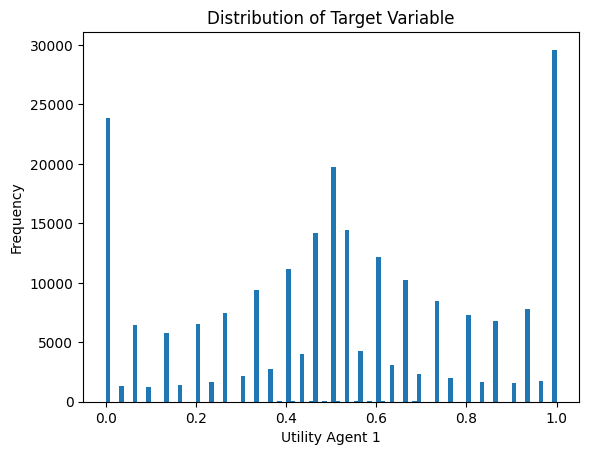

In [10]:
plt.hist(df_train['utility_agent1_scaled'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()



In [11]:
# Define the number of folds for cross-validation
num_folds = 5

# Define the column for stratified or group k-fold
groups_col = 'GameRulesetName'
gkf = GroupKFold(n_splits=num_folds)
split_list = gkf.split(df_train, groups=df_train[groups_col])

#target = 'utility_agent1'
target = 'utility_agent1_scaled'

# Define the parameters
params = {
    'objective': "regression" if target == 'utility_agent1' else "cross_entropy",
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1  # Set lower verbosity
}

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
    y_train, y_val = X_train[target], X_val[target]
    
    # Create LightGBM datasets
    train_data = lgb.Dataset(
        data=X_train[numerical_cols + categorical_cols],
        label=y_train,
        categorical_feature=categorical_cols,
        free_raw_data=True
    )
    val_data = lgb.Dataset(
        data=X_val[numerical_cols + categorical_cols],
        label=y_val,
        categorical_feature=categorical_cols,
        free_raw_data=True
    )

    # Train the model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=[val_data],
        callbacks=[lgb.log_evaluation(period=25)]
    )
    
    # Save the trained model to the list
    trained_models.append(model)

    # predict on validation set
    y_pred = model.predict(X_val[numerical_cols + categorical_cols])

    # Scale back predictions and true values to -1 to 1 range
    if target == "utility_agent1_scaled":
        y_pred = y_pred * 2 - 1
        y_val = y_val * 2 - 1
    
    # Compute RMSE on scaled values
    rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_val
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))



Fold 1
[25]	valid_0's rmse: 0.262457
[50]	valid_0's rmse: 0.253508
[75]	valid_0's rmse: 0.24776
[100]	valid_0's rmse: 0.243965
[125]	valid_0's rmse: 0.24251
[150]	valid_0's rmse: 0.241536
[175]	valid_0's rmse: 0.241011
[200]	valid_0's rmse: 0.239837
[225]	valid_0's rmse: 0.238608
[250]	valid_0's rmse: 0.238205
[275]	valid_0's rmse: 0.237304
[300]	valid_0's rmse: 0.23644
[325]	valid_0's rmse: 0.236015
[350]	valid_0's rmse: 0.235222
[375]	valid_0's rmse: 0.234339
[400]	valid_0's rmse: 0.233941
[425]	valid_0's rmse: 0.233493
[450]	valid_0's rmse: 0.233129
[475]	valid_0's rmse: 0.232784
[500]	valid_0's rmse: 0.232574
[525]	valid_0's rmse: 0.232436
[550]	valid_0's rmse: 0.232267
[575]	valid_0's rmse: 0.231953
[600]	valid_0's rmse: 0.23163
[625]	valid_0's rmse: 0.231649
[650]	valid_0's rmse: 0.231364
[675]	valid_0's rmse: 0.231119
[700]	valid_0's rmse: 0.230989
[725]	valid_0's rmse: 0.2309
[750]	valid_0's rmse: 0.230589
[775]	valid_0's rmse: 0.230384
[800]	valid_0's rmse: 0.230192
[825]	vali

In [12]:
# List of oof scores: [0.4450916886682698, 0.4546972251948946, 0.44912592688792824, 0.4303845889768105, 0.43367937174220084]
# Average oof score: 0.4425957602940208

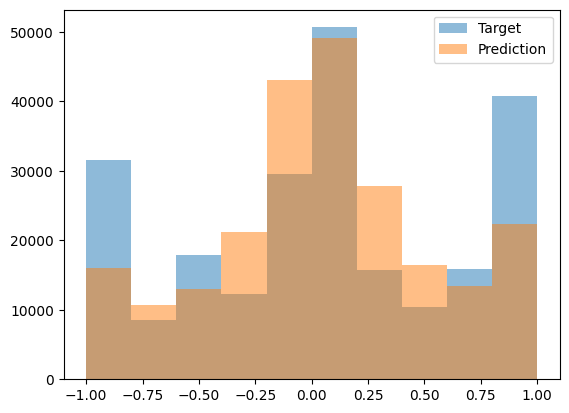

In [13]:
plt.hist(oof['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

In [14]:
# Predict on the test set using all trained models
test_predictions = [
    model.predict(df_test[numerical_cols + categorical_cols]) 
    for model in trained_models
]

# Average predictions from all models
final_predictions = np.mean(test_predictions[0], axis=0)

# Create a DataFrame with the predictions
results_df = pd.DataFrame({
    'Id': df_test['Id'],
    'utility_agent1': final_predictions
})

# Save the results to a CSV file
results_df.to_csv('lightgbm_predictions.csv', index=False)

print("Predictions saved to 'lightgbm_predictions.csv'")

Predictions saved to 'lightgbm_predictions.csv'


***